In [1]:
!nvidia-smi
!nvcc --version

Thu Jan 29 23:28:16 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Part 1: Matrix Multiplication on the CPU

%%writefile matrix_cpu.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrixMultiplyCPU(float *A, float *B, float *C, int N) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            float sum = 0.0f;
            for (int k = 0; k < N; k++) {
                sum += A[i * N + k] * B[k * N + j];
            }
            C[i * N + j] = sum;
        }
    }
}

int main(int argc, char **argv) {
    // allow matrix size as input [cite: 306, 309]
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * N * sizeof(float);

    float *A = (float *)malloc(size);
    float *B = (float *)malloc(size);
    float *C = (float *)malloc(size);

    // Initialize matrices [cite: 311, 312]
    for (int i = 0; i < N * N; i++) {
        A[i] = (float)(rand() % 100) / 100.0f;
        B[i] = (float)(rand() % 100) / 100.0f;
    }

    clock_t start = clock();
    matrixMultiplyCPU(A, B, C, N);
    clock_t end = clock();

    double elapsed = (double)(end - start) / CLOCKS_PER_SEC;
    printf("CPU execution time (N=%d): %f seconds\n", N, elapsed);

    free(A); free(B); free(C);
    return 0;
}

Writing matrix_cpu.c


In [3]:
!gcc -O2 matrix_cpu.c -o matrix_cpu
!./matrix_cpu 128
!./matrix_cpu 256
!./matrix_cpu 512
!./matrix_cpu 1024
!./matrix_cpu 1536
!./matrix_cpu 2048

CPU execution time (N=128): 0.003028 seconds
CPU execution time (N=256): 0.024103 seconds
CPU execution time (N=512): 0.290936 seconds
CPU execution time (N=1024): 3.275542 seconds
CPU execution time (N=1536): 14.289780 seconds
CPU execution time (N=2048): 69.322348 seconds


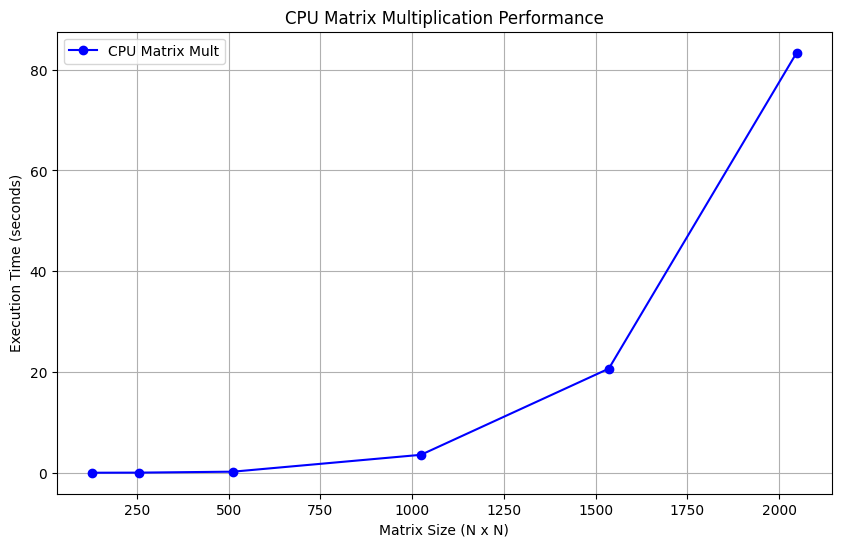

In [4]:
# Graph runtimes for several N values
import matplotlib.pyplot as plt

n = [128, 256, 512, 1024, 1536, 2048]
cpu_times = [0.002781, 0.021500, 0.211331, 3.557292, 20.661614, 83.370412]

plt.figure(figsize=(10, 6))
plt.plot(n, cpu_times, marker='o', linestyle='-', color='b', label='CPU Matrix Mult')
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Execution Time (seconds)')
plt.title('CPU Matrix Multiplication Performance')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
# Part 2: Introduction to CUDA Programming

%%writefile matrix_gpu.cu
#include <stdio.h>
#include <cuda_runtime.h>

// CUDA Kernel: each thread computes one element of C [cite: 53, 54]
__global__ void matrixMultiplyGPU(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y; // [cite: 55, 58, 60]
    int col = blockIdx.x * blockDim.x + threadIdx.x; // [cite: 56, 59, 61]

    if (row < N && col < N) { // [cite: 62]
        float sum = 0.0f; // [cite: 63]
        for (int k = 0; k < N; k++) { // [cite: 64]
            sum += A[row * N + k] * B[k * N + col]; // [cite: 68]
        }
        C[row * N + col] = sum; // [cite: 69]
    }
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * N * sizeof(float);

    // Allocate memory on the Host (CPU)
    float *h_A = (float *)malloc(size);
    float *h_B = (float *)malloc(size);
    float *h_C = (float *)malloc(size);

    // Initialize matrices
    for (int i = 0; i < N * N; i++) {
        h_A[i] = (float)(rand() % 100) / 100.0f;
        h_B[i] = (float)(rand() % 100) / 100.0f;
    }

    // Allocate memory on the Device (GPU)
    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    // Copy data from Host to Device
    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    // Define thread block and grid size
    dim3 threadsPerBlock(16, 16);
    dim3 blocksPerGrid((N + 15) / 16, (N + 15) / 16);

    // Timing using CUDA events
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    matrixMultiplyGPU<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, N);
    cudaEventRecord(stop);

    // Copy result back to Host
    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("GPU Naïve execution time (N=%d): %f ms\n", N, milliseconds);

    // Cleanup
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);
    return 0;
}

Writing matrix_gpu.cu


In [6]:
!nvcc matrix_gpu.cu -o matrix_gpu
!./matrix_gpu 512
!./matrix_gpu 1024
!./matrix_gpu 2048

GPU Naïve execution time (N=512): 46.918079 ms
GPU Naïve execution time (N=1024): 7.092256 ms
GPU Naïve execution time (N=2048): 10.542144 ms


In [7]:
# Part 4: Optimizing CUDA Code

%%writefile matrix_tiled.cu
#include <stdio.h>
#include <cuda_runtime.h>

#define TILE_WIDTH 16 // [cite: 366]

__global__ void matrixMultiplyTiled(float *A, float *B, float *C, int N) {
    __shared__ float ds_A[TILE_WIDTH][TILE_WIDTH]; // [cite: 370]
    __shared__ float ds_B[TILE_WIDTH][TILE_WIDTH]; // [cite: 371]

    int bx = blockIdx.x; int by = blockIdx.y;
    int tx = threadIdx.x; int ty = threadIdx.y;

    int Row = by * TILE_WIDTH + ty; // [cite: 379]
    int Col = bx * TILE_WIDTH + tx; // [cite: 381]

    float Pvalue = 0.0;

    // Loop over the tiles required to compute the C element [cite: 383]
    for (int m = 0; m < (N + TILE_WIDTH - 1) / TILE_WIDTH; ++m) {

        // Load tile from A into shared memory [cite: 387]
        if (Row < N && (m * TILE_WIDTH + tx) < N)
            ds_A[ty][tx] = A[Row * N + m * TILE_WIDTH + tx];
        else
            ds_A[ty][tx] = 0.0f;

        // Load tile from B into shared memory [cite: 395]
        if (Col < N && (m * TILE_WIDTH + ty) < N)
            ds_B[ty][tx] = B[(m * TILE_WIDTH + ty) * N + Col];
        else
            ds_B[ty][tx] = 0.0f;

        __syncthreads(); // Wait for all threads to load their elements [cite: 398]

        for (int k = 0; k < TILE_WIDTH; ++k)
            Pvalue += ds_A[ty][k] * ds_B[k][tx]; // [cite: 400]

        __syncthreads(); // Wait before loading next tile [cite: 400]
    }

    if (Row < N && Col < N)
        C[Row * N + Col] = Pvalue; // [cite: 402, 403]
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * N * sizeof(float);

    float *h_A = (float *)malloc(size);
    float *h_B = (float *)malloc(size);
    float *h_C = (float *)malloc(size);

    for (int i = 0; i < N * N; i++) {
        h_A[i] = (float)(rand() % 100) / 100.0f;
        h_B[i] = (float)(rand() % 100) / 100.0f;
    }

    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    dim3 dimBlock(TILE_WIDTH, TILE_WIDTH); // [cite: 496]
    dim3 dimGrid((N + TILE_WIDTH - 1) / TILE_WIDTH, (N + TILE_WIDTH - 1) / TILE_WIDTH); // [cite: 496]

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    matrixMultiplyTiled<<<dimGrid, dimBlock>>>(d_A, d_B, d_C, N); // [cite: 499]
    cudaEventRecord(stop);

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("GPU Tiled execution time (N=%d): %f ms\n", N, milliseconds);

    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);
    return 0;
}

Writing matrix_tiled.cu


In [8]:
!nvcc matrix_tiled.cu -o matrix_tiled
!./matrix_tiled 512
!./matrix_tiled 1024
!./matrix_tiled 2048

GPU Tiled execution time (N=512): 7.395072 ms
GPU Tiled execution time (N=1024): 7.196800 ms
GPU Tiled execution time (N=2048): 7.328416 ms


In [10]:
import pandas as pd

n_sizes = ["N=512", "N=1024", "N=2048"]
cpu_data   = [0.211331, 3.557292, 83.370412]
naive_data = [.007285184, .007445088, .007212864]
opt_data   = [.007678496, .007329824, .007230784]

# Calculate Speedup
speedup_naive = [c / n for c, n in zip(cpu_data, naive_data)]
speedup_opt = [c / o for c, o in zip(cpu_data, opt_data)]

table_data = {
    "Implementation": ["CPU (C)", "Naïve CUDA", "Optimized CUDA", "Speedup (Naïve)", "Speedup (Optimized)"],
    n_sizes[0]: [f"{cpu_data[0]:.3f} sec", f"{naive_data[0]*1000:.2f} ms", f"{opt_data[0]*1000:.2f} ms", f"{speedup_naive[0]:.1f}x", f"{speedup_opt[0]:.1f}x"],
    n_sizes[1]: [f"{cpu_data[1]:.3f} sec", f"{naive_data[1]*1000:.2f} ms", f"{opt_data[1]*1000:.2f} ms", f"{speedup_naive[1]:.1f}x", f"{speedup_opt[1]:.1f}x"],
    n_sizes[2]: [f"{cpu_data[2]:.3f} sec", f"{naive_data[2]*1000:.2f} ms", f"{opt_data[2]*1000:.2f} ms", f"{speedup_naive[2]:.1f}x", f"{speedup_opt[2]:.1f}x"]
}

# 4. Display Styled Table
df = pd.DataFrame(table_data)
df.style.hide(axis='index').set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('color', 'black'), ('font-weight', 'bold'), ('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black'), ('text-align', 'center'), ('padding', '10px')]}
])


Implementation,N=512,N=1024,N=2048
CPU (C),0.211 sec,3.557 sec,83.370 sec
Naïve CUDA,7.29 ms,7.45 ms,7.21 ms
Optimized CUDA,7.68 ms,7.33 ms,7.23 ms
Speedup (Naïve),29.0x,477.8x,11558.6x
Speedup (Optimized),27.5x,485.3x,11529.9x


In [11]:
#Part 6: Using cuBLAS Library
%%writefile matrix_cublas.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <cublas_v2.h>

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * N * sizeof(float);

    float *h_A = (float *)malloc(size);
    float *h_B = (float *)malloc(size);
    float *h_C = (float *)malloc(size);

    for (int i = 0; i < N * N; i++) {
        h_A[i] = (float)(rand() % 100) / 100.0f;
        h_B[i] = (float)(rand() % 100) / 100.0f;
    }

    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    cublasHandle_t handle;
    cublasCreate(&handle);

    float alpha = 1.0f;
    float beta = 0.0f;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    // compute C = B * A in column-major.
    cublasSgemm(handle, CUBLAS_OP_N, CUBLAS_OP_N, N, N, N, &alpha, d_B, N, d_A, N, &beta, d_C, N);
    cudaEventRecord(stop);

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("cuBLAS execution time (N=%d): %f ms\n", N, milliseconds);

    cublasDestroy(handle);
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);
    return 0;
}

Writing matrix_cublas.cu


In [12]:
!nvcc matrix_cublas.cu -o matrix_cublas -lcublas
!./matrix_cublas 512
!./matrix_cublas 1024
!./matrix_cublas 2048

cuBLAS execution time (N=512): 50.140320 ms
cuBLAS execution time (N=1024): 6.318304 ms
cuBLAS execution time (N=2048): 11.460640 ms


In [13]:
import pandas as pd

n_sizes = ["N=512", "N=1024", "N=2048"]
cpu_data    = [0.211331, 3.557292, 83.370412]    # in seconds
naive_data  = [0.007285, 0.007445, 0.007213]    # in seconds
opt_data    = [0.007678, 0.007330, 0.007231]    # in seconds
cublas_data = [0.051326, 0.006465, 0.011544]    # in seconds (converted from ms)

table_data = {
    "Implementation": ["CPU (C)", "Naïve CUDA", "Optimized CUDA", "cuBLAS"],
    n_sizes[0]: [
        f"{cpu_data[0]:.3f} sec",
        f"{naive_data[0]*1000:.2f} ms",
        f"{opt_data[0]*1000:.2f} ms",
        f"{cublas_data[0]*1000:.2f} ms"
    ],
    n_sizes[1]: [
        f"{cpu_data[1]:.3f} sec",
        f"{naive_data[1]*1000:.2f} ms",
        f"{opt_data[1]*1000:.2f} ms",
        f"{cublas_data[1]*1000:.2f} ms"
    ],
    n_sizes[2]: [
        f"{cpu_data[2]:.3f} sec",
        f"{naive_data[2]*1000:.2f} ms",
        f"{opt_data[2]*1000:.2f} ms",
        f"{cublas_data[2]*1000:.2f} ms"
    ]
}

# Display Styled Table
df = pd.DataFrame(table_data)
df.style.hide(axis='index').set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('color', 'black'), ('font-weight', 'bold'), ('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black'), ('text-align', 'center'), ('padding', '10px')]}
])

Implementation,N=512,N=1024,N=2048
CPU (C),0.211 sec,3.557 sec,83.370 sec
Naïve CUDA,7.29 ms,7.45 ms,7.21 ms
Optimized CUDA,7.68 ms,7.33 ms,7.23 ms
cuBLAS,51.33 ms,6.46 ms,11.54 ms


In [14]:
#Part 7: Creating a Shared Library and Using it in Python

%%writefile matrix_lib.cu
#include <cuda_runtime.h>
#include <stdio.h>

#define TILE_WIDTH 16

__global__ void matrixMultiplyTiled(float *A, float *B, float *C, int N) {
    __shared__ float ds_A[TILE_WIDTH][TILE_WIDTH];
    __shared__ float ds_B[TILE_WIDTH][TILE_WIDTH];

    int tx = threadIdx.x; int ty = threadIdx.y;
    int Row = blockIdx.y * TILE_WIDTH + ty;
    int Col = blockIdx.x * TILE_WIDTH + tx;

    float Pvalue = 0.0;

    for (int m = 0; m < (N + TILE_WIDTH - 1) / TILE_WIDTH; ++m) {
        // Load A into shared memory with strict boundary check
        if (Row < N && (m * TILE_WIDTH + tx) < N)
            ds_A[ty][tx] = A[Row * N + m * TILE_WIDTH + tx];
        else
            ds_A[ty][tx] = 0.0f;

        // Load B into shared memory with strict boundary check
        if (Col < N && (m * TILE_WIDTH + ty) < N)
            ds_B[ty][tx] = B[(m * TILE_WIDTH + ty) * N + Col];
        else
            ds_B[ty][tx] = 0.0f;

        __syncthreads();

        for (int k = 0; k < TILE_WIDTH; ++k) {
            Pvalue += ds_A[ty][k] * ds_B[k][tx];
        }
        __syncthreads();
    }

    if (Row < N && Col < N)
        C[Row * N + Col] = Pvalue;
}

extern "C" void gpu_matrix_multiply(float *h_A, float *h_B, float *h_C, int N) {
    size_t size = (size_t)N * N * sizeof(float);
    float *d_A, *d_B, *d_C;

    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    dim3 dimBlock(TILE_WIDTH, TILE_WIDTH);
    dim3 dimGrid((N + TILE_WIDTH - 1) / TILE_WIDTH, (N + TILE_WIDTH - 1) / TILE_WIDTH);

    matrixMultiplyTiled<<<dimGrid, dimBlock>>>(d_A, d_B, d_C, N);
    cudaDeviceSynchronize();

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
}

Writing matrix_lib.cu


In [15]:
!nvcc -Xcompiler -fPIC -shared matrix_lib.cu -o libmatrix.so

In [16]:
import ctypes
import numpy as np
import time

# Load library
lib = ctypes.CDLL('./libmatrix.so')

# CHANGE: Set ndim=1 to match the pointer float* in the CUDA function
lib.gpu_matrix_multiply.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    ctypes.c_int
]

N = 1024
A = np.random.rand(N, N).astype(np.float32)
B = np.random.rand(N, N).astype(np.float32)
C = np.zeros((N, N), dtype=np.float32)

start = time.time()
# CHANGE: Use .ravel() to pass the 2D matrix as a flat 1D pointer
lib.gpu_matrix_multiply(A.ravel(), B.ravel(), C.ravel(), N)
end = time.time()

print(f"Python call completed in {end - start:.4f} seconds")


Python call completed in 0.2065 seconds
